# Exercise 4: Circuit Decomposition
Wow! If you managed to solve the first three exercises, congratulations! The fourth problem is supposed to puzzle even the quantum experts among you, so don’t worry if you cannot solve it. If you can, hats off to you!

You may recall from your quantum mechanics course that quantum theory is unitary. Therefore, the evolution of any (closed) system can be described by a unitary. But given an arbitrary unitary, can you actually implement it on your quantum computer?

**"A set of quantum gates is said to be universal if any unitary transformation of the quantum data can be efficiently approximated arbitrarily well as a sequence of gates in the set."** (https://qiskit.org/textbook/ch-algorithms/defining-quantum-circuits.html)

Every gate you run on the IBM Quantum Experience is transpiled into single qubit rotations and CNOT (CX) gates. We know that these constitute a universal gate set, which implies that any unitary can be implemented using only these gates. However, in general it is not easy to find a good decomposition for an arbitrary unitary. Your task is to find such a decomposition.

You are given the following unitary:

In [5]:
from may4_challenge.ex4 import get_unitary
U = get_unitary()
# print(U)
print("U has shape", U.shape)

U has shape (16, 16)


#### What circuit would make such a complicated unitary?

Is there some symmetry, or is it random? We just updated Qiskit with the introduction of a quantum circuit library (https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library). This library gives users access to a rich set of well-studied circuit families, instances of which can be used as benchmarks (quantum volume), as building blocks in building more complex circuits (adders), or as tools to explore quantum computational advantage over classical computation (instantaneous quantum polynomial complexity circuits).

In [6]:
from qiskit import QuantumCircuit
from may4_challenge.ex4 import check_circuit, submit_circuit

#additional deps for learning and exploring the problem
%matplotlib inline

from qiskit import *
from qiskit.quantum_info import Operator
import numpy as np
import scipy as scipy
import seaborn as sns
import matplotlib as mpl
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler import PassManager
from qiskit.extensions import UnitaryGate
from scipy.ndimage.interpolation import rotate
from may4_challenge.ex4 import check_circuit, submit_circuit
from scipy.linalg import hadamard
import math
from cmath import rect
from sympy import *
from IPython.display import display

init_printing()

**Using only single qubit rotations and CNOT gates, find a quantum circuit that approximates that unitary $U$ by a unitary $V$ up to an error $\varepsilon = 0.01$, such that $\lVert U - V\rVert_2 \leq \varepsilon$ !** 

Note that the norm we are using here is the spectral norm, $\qquad \lVert A \rVert_2 = \max_{\lVert \psi \rVert_2= 1} \lVert A \psi \rVert$.

This can be seen as the largest scaling factor that the matrix $A$ has on any initial (normalized) state $\psi$. One can show that this norm corresponds to the largest singular value of $A$, i.e., the square root of the largest eigenvalue of the matrix $A^\dagger A$, where $A^{\dagger}$ denotes the conjugate transpose of $A$.

**When you submit a circuit, we remove the global phase of the corresponding unitary $V$ before comparing it with $U$ using the spectral norm. For example, if you submit a circuit that generates $V = \text{e}^{i\theta}U$, we remove the global phase $\text{e}^{i\theta}$ from $V$ before computing the norm, and you will have a successful submission. As a result, you do not have to worry about matching the desired unitary, $U$, up to a global phase.**

As the single-qubit gates have a much higher fidelity than the two-qubit gates, we will look at the number of CNOT-gates, $n_{cx}$, and the number of u3-gates, $n_{u3}$, to determine the cost of your decomposition as 

$$
\qquad \text{cost} = 10 \cdot n_{cx} + n_{u3}
$$

Try to optimize the cost of your decomposition. 

**Note that you will need to ensure that your circuit is composed only of $u3$ and $cx$ gates. The exercise is considered correctly solved if your cost is smaller than 1600.**

---
For useful tips to complete this exercise as well as pointers for communicating with other participants and asking questions, please take a look at the following [repository](https://github.com/qiskit-community/may4_challenge_exercises). You will also find a copy of these exercises, so feel free to edit and experiment with these notebooks.

---

# Solution:

let's define some helper functions to get rid of some code further down

In [13]:
def plot_matrix(mat, plot_type='default'):
    if plot_type == 'default' or plot_type == 'all':
        fig, axs = mpl.pyplot.subplots(1, 2, figsize=(20, 8))
        im1 = axs[0].imshow(np.abs(mat), cmap='hot', interpolation='bilinear', vmin=0, vmax=1)
        axs[0].set_title('Magnitude')
        fig.colorbar(im1, ax=axs[0])
        im2 = axs[1].imshow(np.angle(mat), cmap='hot', interpolation='bilinear', vmin=-np.pi, vmax=np.pi)
        axs[1].set_title('Phase')
        fig.colorbar(im2, ax=axs[1])

    if plot_type == 'sns' or plot_type == 'all':
        fig, ax = mpl.pyplot.subplots(1, 2, figsize=(20, 8))
        sns.heatmap(np.abs(mat), annot=True, fmt = '0.2f', linewidths=.5, ax=ax[0])
        ax[0].set_title('Magnitude')
        sns.heatmap(np.angle(mat), annot=True, fmt = '0.2f', linewidths=.5, ax=ax[1])
        ax[1].set_title('Phase')
    
    #mpl.pyplot.show()
    
    #fig1, ax1 = mpl.pyplot.subplots(figsize=(10,10))
    #sns.heatmap(np.abs(mat), annot=True, fmt = '0.2f', linewidths=.5, ax=ax1)
    #mpl.pyplot.show()
    #fig2, ax2 = mpl.pyplot.subplots(figsize=(20,20))
    #U2_1 = rotate(mat.real, angle=45)
    #U2_2 = rotate(mat.imag, angle=45)
    #U2 = U2_1 + 1j*U2_2
    #M2 = np.absolute(U2)
    #sns.heatmap(M2, annot =True, fmt = '0.2f', linewidths=.5, ax=ax2)

def plot_circuit(qc):
    plot_matrix(Operator(qc).data)

# Reference: https://github.com/zjiang23/CS269Q-RQSS/blob/master/qft.py
# Reference: https://courses.edx.org/c4x/BerkeleyX/CS191x/asset/chap5.pdf (Page 2)
def QFT_mat2(n):
    omega = np.exp(2.0 * np.pi * 1j / n)
    mat = np.ones((n, n), dtype=complex)
    
    for i in range(1, n):
        for j in range(1, n):
            mat[i, j] = omega ** (i * j)

    mat /= math.sqrt(float(n))
    return mat

def QFT_mat(n):
    NN = 2**n
    QFN = np.zeros([NN,NN],dtype=np.complex_)
    for i in range(NN):
        for j in range(NN):
            if (i == 0) or (j == 0):
                QFN[i,j] = 1
            else:
                QFN[i,j] = np.exp((2*np.pi*1j)*(i*j)/NN)
    return QFN

# The following for loop is to replace very small values ( < 1e-14) from computational error with zero,
# this way when calculating the phase we will get zero rather than random values
def filter_mat(m):
    m_ret = np.zeros(shape=m.shape, dtype=m.dtype)
    for i in range(len(m)):
        for j in range(len(m[i])):
            m_ret[i,j] = m[i,j]
            if 0 < np.real(m_ret[i,j]) < 1e-14:
                m_ret[i,j] = 0 + 1j*(np.imag(m_ret[i,j]))
            if -1e-14 < np.real(m_ret[i,j]) < 0:
                m_ret[i,j] = 0 + 1j*(np.imag(m_ret[i,j]))
            if 0 < np.imag(m_ret[i,j]) < 1e-14:
                m_ret[i,j] = np.real(m_ret[i,j]) + 1j*0
            if -1e-14 < np.imag(m_ret[i,j]) < 1e-14:
                m_ret[i,j] = np.real(m_ret[i,j]) + 1j*0
    return m_ret

def rad_sum(a, b):
    sinAB = sin(a) * cos(b) + cos(a) * sin(b)
    cosAB = cos(a) * cos(b) - sin(a) * sin(b)
    return atan2(sinAB, cosAB)

real2rational = np.vectorize(Rational)
m_rad_sum = np.vectorize(rad_sum)

def real2rationalPI(m):
    ret = m/np.pi # divide by pi to help to rationalize
    ret = real2rational(ret)
    ret = ret * pi # add pi back
    return ret

In [14]:
def unoptimized():
    # 1676
    qc1 = QuantumCircuit(4)
    qc1.iso(np.matmul(U,U.transpose().conj()),[0,1,2,3],[])
    #qc1.iso(U,[0,1,2,3],[])
    new_circ=transpile(qc1,basis_gates=['u3','cx'],optimization_level=3)
    return new_circ

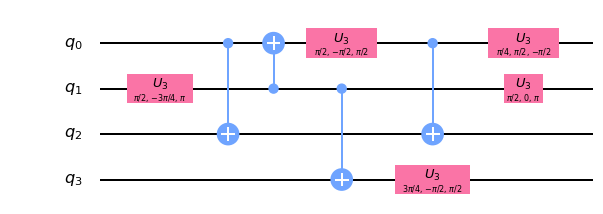

In [12]:
def optimized1():
    #1447
    qc1 = QuantumCircuit(4)
    #np.matmul(U,U.transpose().conj())
    #H = hadamard(16, dtype=complex)
    H = hadamard(16, dtype=complex)
    #plot_matrix(H)
    H = H/4
    U2 = U
    #plot_matrix(H)
    #H = np.kron(H, H)
    #H = H.dot(H)
    #H = np.kron(np.kron(H,H), np.kron(H,H))
    #foo = np.matmul(U,U.transpose().conj())
    U2 = H.dot(U2)
    #U2 = np.kron(H, U2)
    #U2 = H.dot(U)
    #plot_matrix(U2)
    #U2 = U
    qc1.iso(np.matmul(U2,U2.transpose().conj()),[0,1,2,3],[])
    qc1.iso(U2,[0,1,2,3],[])
    qc1.h(0)
    qc1.h(1)
    qc1.h(2)
    qc1.h(3)
    new_circ=transpile(qc1,basis_gates=['u3','cx'],optimization_level=3)

    #new_circ = transpile(qc, basis_gates=['u3', 'cx'], optimization_level=2)
    #new_circ.draw(output='mpl')
    return new_circ

def optimized2():
    qc = QuantumCircuit(4)
    H = hadamard(16, dtype=complex)/4
    #plot_matrix(H)
    U2 = U
    U2 = H.dot(U2)
    #U2 = U2.dot(H)
    #qc.h([0, 1, 2, 3])
    #qc.sdag([0, 1, 2, 3])
    #M1 = Operator(qc).data
    plot_matrix(U2)
    #U2 = M1.dot(U2)
    qc.iso(U2,[0, 1, 2, 3],[])
    #plot_circuit(qc)
    #plot_matrix(U2)
    #qc.unitary(U2, [0, 1, 2, 3], label='U')
    #qc.h([0, 1, 2, 3])
    #plot_circuit(qc)
    return transpile(qc,basis_gates=['u3','cx'],optimization_level=3)

def optimized3():
    plot_matrix(U)
    plot_matrix(U.transpose().conj())
    plot_matrix(np.matmul(U,U.transpose().conj()))
    backend = Aer.get_backend('unitary_simulator')

    q = QuantumRegister(4, 'q')
    H = hadamard(16, dtype=complex)
    U2 = H.dot(U)
    qc = QuantumCircuit(4)
    gate4x4 = UnitaryGate(U)
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.iso(U2, [0, 1, 2, 3], [])
    qc.append(gate4x4, [q[0], q[1], q[2], q[3]] )
    qc.draw(output='mpl')
    qc1 = transpile(qc, gates=['u', 'cx'])
    qc1.draw()

    job = execute(qc, backend)
    result = job.result()
    transpiled_unitary = result.get_unitary(qc, decimals=3)

    plot_matrix(transpiled_unitary)
    print(result.get_unitary(qc, decimals=3))

    qc1 = QuantumCircuit(4)
    qc1.h(0)
    qc1.cx(0, 1)
    had = scipy.linalg.hadamard(16)

    qc1.cx(1, 0)
    qc1.h(1)
    qc1.iso(U)
    job1 = execute(qc1, backend)
    result1 = job1.result()
    transpiled_unitary1 = result1.get_unitary(qc1, decimals=3)
    print(transpiled_unitary1)
    plot_matrix(transpiled_unitary1)

    pass_ = Unroller(['u3', 'cx'])
    pm = PassManager(pass_)
    new_circ = pm.run(qc)
    new_circ.draw(output='mpl')

def optimized4():
    num_qbit = 4
    num_qbit_list = list(range(num_qbit))
    #plot_matrix(U, 'default')
    
    QF4 = QFT_mat(num_qbit) # 4 qubit QFT matrix
    QF4_inv = np.linalg.inv(QF4) # 4 qubit inverse QFT matrix
    QUQ_raw = np.matmul(QF4_inv,np.matmul(U,QF4))
    QUQ = QUQ_raw.copy()
    QUQ.real[abs(QUQ.real) < 1e-14] = 0.0
    QUQ.imag[abs(QUQ.imag) < 1e-14] = 0.0
    #QUQ2 = filter_mat(QUQ_raw)
    #plot_matrix(QUQ_raw, 'default')
    #plot_matrix(QUQ, 'default')
    #plot_matrix(QUQ2, 'default')
    
    H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]]) # 1 qubit Hadamard
    H4 = np.kron(H,np.kron(H,np.kron(H,H))) # 4 qbuit Hadamard
    HUH_raw = np.matmul(H4,np.matmul(U,H4))
    HUH = filter_mat(HUH_raw)
    #plot_matrix(HUH, 'default')
    
    qc2 = QuantumCircuit(num_qbit)
    qc2.h(num_qbit_list)
    qc2.iso(HUH, num_qbit_list, [])
    qc2.h(num_qbit_list)
    qc2 = transpile(qc2, basis_gates = ['u3', 'cx'], optimization_level=2,)
    
    HUH_diag = np.diagonal(HUH)
    HUH_diag = np.around(HUH_diag, 8) # round to 8 decimals to help to rationalize
    #HUH_diag_t = np.arctan2(np.imag(HUH_diag),np.real(HUH_diag)) # convert to radians
    HUH_diag_real_phases = np.angle(HUH_diag)
    HUH_diag_rational_phases = real2rationalPI(HUH_diag_real_phases)
    #print(HUH_diag_rational_phases)
    #display(Array(HUH_diag_rational_phases))
    
    # let's take only the phases where one qbit is flipped (power of 2 starting from 1 to num_qbit)
    single_qbit_shift = np.array(list(map(lambda x : HUH_diag_real_phases[x], [1 << i for i in range(num_qbit)])), dtype='float64')
    single_qbit_shift_rational = real2rationalPI(single_qbit_shift)
    #print(single_qbit_shift_rational)
    #display(Array(single_qbit_shift_rational))
    
    qcp = QuantumCircuit(num_qbit)
    for i in range(num_qbit):
        qcp.u3(0,single_qbit_shift[i],0,i)
    
    U_simulator = Aer.get_backend('unitary_simulator')
    
    result = execute(qcp, backend = U_simulator).result()
    P = result.get_unitary()
    P_diag = np.diagonal(P)
    P_diag = np.around(P_diag, 8) # round to 8 decimals to help to rationalize
    P_diag_real_phases = np.angle(P_diag)
    P_diag_rational_phases = real2rationalPI(P_diag_real_phases)
    #display(Array(P_diag_rational_phases))
    
    phase_diff = m_rad_sum(P_diag_rational_phases, HUH_diag_rational_phases * -1)
    #display(Array(phase_diff))
    #print(phase_diff) # [0 0 0 pi 0 pi pi pi 0 0 pi 0 0 pi 0 0]
    
    # we shift phases with a cx gate across 2 qbits according to the following truth table
    #  3210 |
    # ------+---
    #  0000 | 0
    #  0001 | 0
    #  0010 | 0
    #  0011 | 180 <- 0-1
    #  0100 | 0
    #  0101 | 180 <- 0-2
    #  0110 | 180 <- 1-2
    #  0111 | 180 <- 0-1-2 - we already already shift phase due to weaker condition 0-1 and 0-2
    #  1000 | 0
    #  1001 | 0
    #  1010 | 180 <- 1-3
    #  1011 | 0
    #  1100 | 0
    #  1101 | 180 <- 0-2-3 - we already already shift phase due to weaker condition 0-2
    #  1110 | 0
    #  1111 | 0
    
    qbits_needing_cz = []
    for idx in range(len(phase_diff)):
        phase = phase_diff[idx]
        if bin(idx).count("1") == 2 and phase == pi:
            bits = []
            for i, c in enumerate(bin(idx)[:1:-1], 0):
                if c == '1':
                    bits.append(i)
            qbits_needing_cz.append(bits)
    
    qc4 = QuantumCircuit(4)
    qc4.h(num_qbit_list)
    qc4.barrier()
    for qbits in qbits_needing_cz:
        qc4.cz(qbits[0], qbits[1])
    qc4.barrier()
    for i in range(num_qbit):
        qc4.u3(0,single_qbit_shift[i],0,i)
    qc4.barrier()
    qc4.h(num_qbit_list)
    
    print(qbits_needing_cz)
    
    qc5 = QuantumCircuit(num_qbit)
    qc5.h(num_qbit_list)
    #for qbits in qbits_needing_cz:
        #qc5.cz(qbits[0], qbits[1])
    qc5.cz(qbits_needing_cz[0][0], qbits_needing_cz[0][1])
    qc5.cz(qbits_needing_cz[1][0], qbits_needing_cz[1][1])
    qc5.cz(qbits_needing_cz[2][0], qbits_needing_cz[2][1])
    qc5.cz(qbits_needing_cz[3][0], qbits_needing_cz[3][1])
    for i in range(num_qbit):
        qc5.u3(0,single_qbit_shift[i],0,i)
    qc5.h(num_qbit_list)
    qc5 = transpile(qc5, basis_gates = ['u3', 'cx'], optimization_level=2,)
    
    qc6 = QuantumCircuit(num_qbit)
    qc6.h(num_qbit_list)
    qc6.cz(qbits_needing_cz[0][0], qbits_needing_cz[0][1])
    qc6.cz(qbits_needing_cz[1][0], qbits_needing_cz[1][1])
    qc6.cz(qbits_needing_cz[2][0], qbits_needing_cz[2][1])
    qc6.cz(qbits_needing_cz[3][0], qbits_needing_cz[3][1])
    for i in range(num_qbit):
        qc6.u3(0,single_qbit_shift[i],0,i)
    qc6.h(num_qbit_list)
    qc6 = transpile(qc6, basis_gates = ['u3', 'cx'], optimization_level=2,)
    
    return qc6

def optimized5():
    # I multiplied gates to U in order to obtain the identity.
    # I did this per qubit, that's, first I transformed U to I kron V,
    # and then I repeat per qubit. Finally, 
    # I reduce the circuit size combining u3 gates and employing a c-not identity.
    qc1 = QuantumCircuit(4)
    qc1.u3(np.pi/2,-3*np.pi/4,np.pi,1)
    qc1.cx(0, 2)
    qc1.cx(1, 0)
    qc1.u3(np.pi/2,-np.pi/2,np.pi/2,0)
    qc1.cx(1, 3)
    qc1.cx(0, 2)
    qc1.u3(3*np.pi/4,-np.pi/2,np.pi/2,3)
    qc1.u3(np.pi/4,np.pi/2,-np.pi/2,0)
    qc1.u3(np.pi/2,0,np.pi,1)
    qc1 = transpile(qc1, basis_gates = ['u3', 'cx'], optimization_level=2,)

    return qc1

#plot_matrix(U)
#new_circ = optimized1()
#new_circ = optimized2()
#new_circ = optimized3()
#new_circ = optimized4()
new_circ = optimized5()
new_circ.draw(output='mpl')
#check_circuit(new_circ)
#plot_circuit(new_circ)
#check_circuit(new_circ) 1.749587988194679e-15

In [10]:
##### check your quantum circuit by running the next line
check_circuit(qc)

Circuit stats:
||U-V||_2 = 1.9876050222189336
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Unable to compute cost: double check your circuit is made of `u3` and `cx` gates only.

Something is not right with your circuit: the circuit contains something else than `u3` and `cx` gates


You can check whether your circuit is valid before submitting it with `check_circuit(qc)`. Once you have a valid solution, please submit it by running the following cell (delete the `#` before `submit_circuit`). You can re-submit at any time.


In [ ]:
# Send the circuit as the final answer, can re-submit at any time
#submit_circuit(qc) 